# Lab 6 - MNIST

## Overview of the MNIST Dataset

The MNIST Dataset stands for "Modified National Institute of Standards and Technology". The dataset contains a collection of handwritten digits that are used for training image processing systems. The dataset contains 60,000 training images and 10,000 testing images that are all 28x28 pixel grayscale images. Each image contains a handwritten digit from 0-9. 

## Imports

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Preprocess the Data

Preprocessing improves effieciency and accuracy for machine learning models. Preprocessing for the MNIST dataset images will be done using torchvision.transforms.
The following transforms will be applied to the images:

- ToTensor: Converts the image to a PyTorch tensor.
- Normalize: Helps get data within a range and reduces skewness.

In [3]:
# transforms.Compose() is used to chain multiple transformations together
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Create the training and valid datasets
trainDataset = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
validDataset = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

## Create a PyTorch Dataloader

In [5]:
BATCH_SIZE = 64
# Data loaders for the training dataset and valid dataset
trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size = BATCH_SIZE, shuffle = True)
validLoader = torch.utils.data.DataLoader(validDataset, batch_size = BATCH_SIZE, shuffle = True)

## Plot the Sample Images

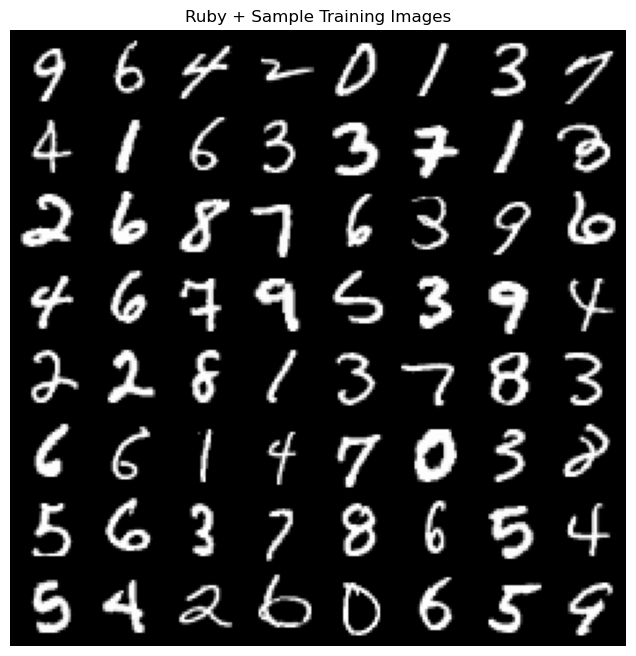

In [7]:
# Plot samples
sample_batch = next(iter(trainLoader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Ruby + Sample Training Images")
plt.imshow(np.transpose(make_grid(sample_batch[0], padding=1, normalize=True),(1,2,0)));

## Build the CNN Model

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 8, (3, 3)), # 1 input channel, 8 output channels, 3x3 kernel
            nn.ReLU(),  
            nn.MaxPool2d((2, 2)), # Kernel size of 2x2
            nn.Conv2d(8, 16, (3, 3)), # 8 input channels, 16 output channels, 3x3 kernel
            nn.ReLU(),
            nn.MaxPool2d((3, 3)), # Kernel size or 3x3
            nn.Flatten(),
            nn.Linear(144, 10) # Fully connected linear layer, 144 input size, 10 output size
        )
    def forward(self, x):
        out = self.main(x)
        return out

## Set Up the Trainer

In [11]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    train_loss, valid_loss, valid_accuracy = [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        model.train()
        for X, y in trainloader:
            
            optimizer.zero_grad()  # Reset gradients
            y_hat = model(X)  # Forward pass: compute the model's prediction
            loss = criterion(y_hat, y)  # Compute loss between predicted values and actual labels
            loss.backward()  # Backpropagation: compute gradients
            optimizer.step()  # Update model parameters using optimizer
            train_batch_loss += loss.item()  # Accumulate batch loss
        train_loss.append(train_batch_loss / len(trainloader))  # Compute average training loss for this epoch
        
        # Validation
        model.eval()  # Set the model to evaluation mode (disables dropout/batchnorm layers if any)
        with torch.no_grad():  # Stop gradient computation to save memory
            correct = 0
            total = 0
            for X, y in validloader:
                
                y_hat = model(X)  # Forward pass: compute predictions for validation set
                loss = criterion(y_hat, y)  # Compute validation loss
                valid_batch_loss += loss.item()  # Accumulate validation batch loss
                
                # Compute accuracy: argmax to get predicted class, compare with actual labels
                _, predicted = torch.max(y_hat, 1)  # Get class predictions
                correct += (predicted == y).sum().item()  # Count correct predictions
                total += y.size(0)  # Update total samples
            valid_loss.append(valid_batch_loss / len(validloader))  # Compute average validation loss for this epoch
            valid_accuracy.append(100 * correct / total)  # Compute accuracy as percentage
            
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}%.")
    
    results = {"train_loss": train_loss,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results


## Summarize the Model

In [13]:
model = CNN()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
         MaxPool2d-3            [-1, 8, 13, 13]               0
            Conv2d-4           [-1, 16, 11, 11]           1,168
              ReLU-5           [-1, 16, 11, 11]               0
         MaxPool2d-6             [-1, 16, 3, 3]               0
           Flatten-7                  [-1, 144]               0
            Linear-8                   [-1, 10]           1,450
Total params: 2,698
Trainable params: 2,698
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.01
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


## Train the Model

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = trainer(model, criterion, optimizer, trainLoader, validLoader, epochs=50)

Epoch 1: Train Loss: 0.382. Valid Loss: 0.122. Valid Accuracy: 96.34%.
Epoch 2: Train Loss: 0.117. Valid Loss: 0.092. Valid Accuracy: 97.11%.
Epoch 3: Train Loss: 0.091. Valid Loss: 0.087. Valid Accuracy: 97.43%.
Epoch 4: Train Loss: 0.078. Valid Loss: 0.071. Valid Accuracy: 97.80%.
Epoch 5: Train Loss: 0.068. Valid Loss: 0.066. Valid Accuracy: 97.97%.
Epoch 6: Train Loss: 0.062. Valid Loss: 0.069. Valid Accuracy: 97.80%.
Epoch 7: Train Loss: 0.059. Valid Loss: 0.063. Valid Accuracy: 98.02%.
Epoch 8: Train Loss: 0.054. Valid Loss: 0.055. Valid Accuracy: 98.23%.
Epoch 9: Train Loss: 0.050. Valid Loss: 0.057. Valid Accuracy: 98.28%.
Epoch 10: Train Loss: 0.048. Valid Loss: 0.059. Valid Accuracy: 98.18%.
Epoch 11: Train Loss: 0.046. Valid Loss: 0.055. Valid Accuracy: 98.34%.
Epoch 12: Train Loss: 0.045. Valid Loss: 0.056. Valid Accuracy: 98.23%.
Epoch 13: Train Loss: 0.043. Valid Loss: 0.052. Valid Accuracy: 98.43%.
Epoch 14: Train Loss: 0.042. Valid Loss: 0.054. Valid Accuracy: 98.35%.
E

## Visualize Training Loss Over Epochs

The graph indicates my model is learning and improving since loss is decreasing. 

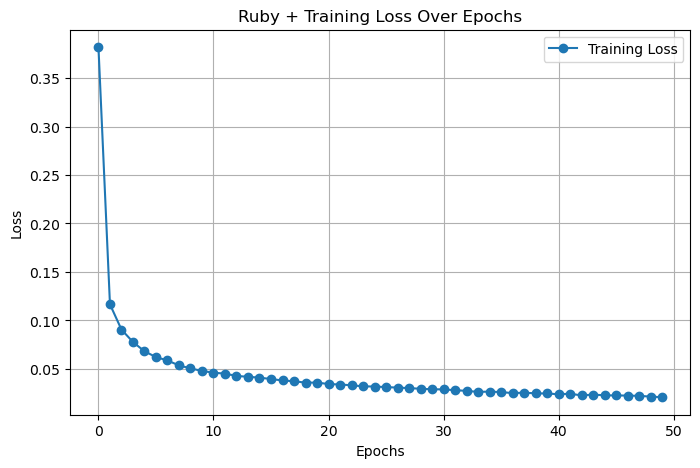

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(results['train_loss'], label='Training Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Ruby + Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Visualize Validation Loss Over Epochs

The decreasing validation loss indicates the model is generalizing well to unseen data.

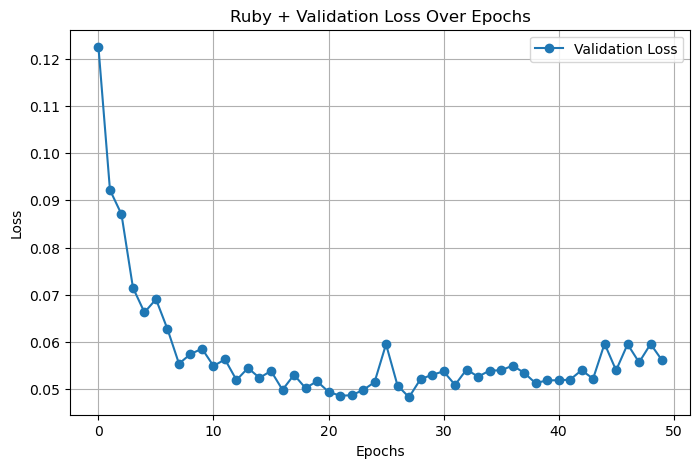

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(results['valid_loss'], label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Ruby + Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Visualize Validation Accuracy Over Epochs

The increase in validation accuracy indicates the model is progressively learning to better generalize the data.

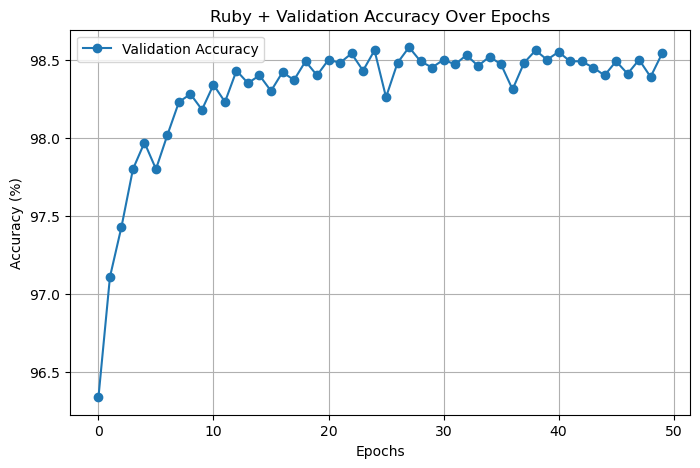

In [21]:
plt.figure(figsize=(8, 5))
plt.plot(results['valid_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Ruby + Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Visualize Actual vs Predicted Results

This visual only contains 64 images but it shows that for those images, the model is able to correctly label almost each one. 

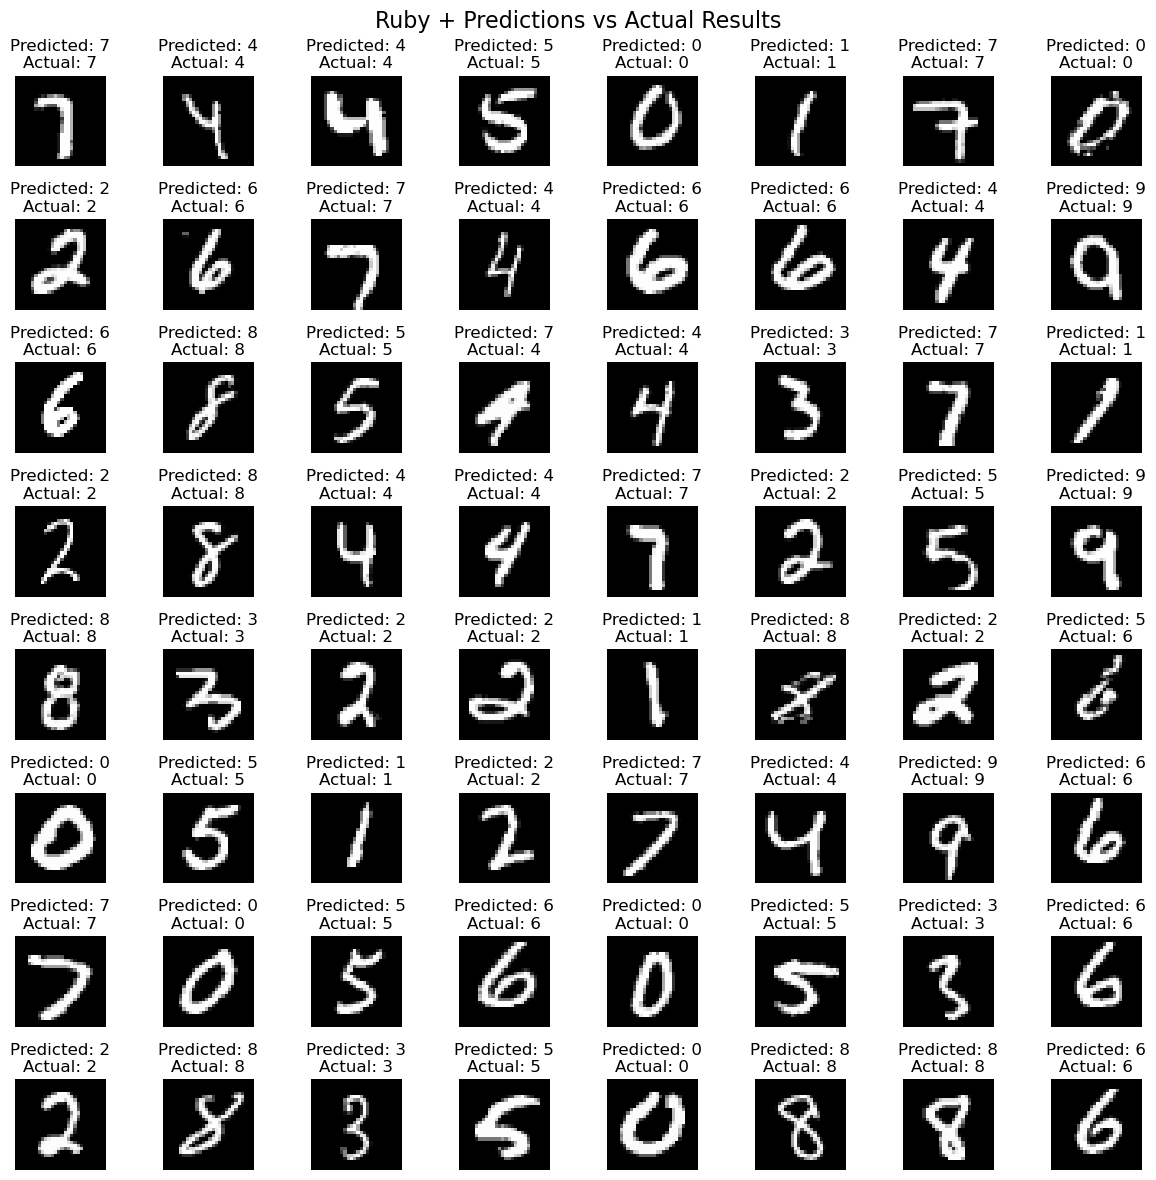

In [23]:
# Get a batch of validation images and results
images, labels = next(iter(validLoader))

# Get model predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(12, 12))
plt.suptitle("Ruby + Predictions vs Actual Results", fontsize = 16)
# Show 64 images
for i in range(64):  
    plt.subplot(8, 8, i + 1)  
    plt.imshow(images[i].squeeze(), cmap="gray")  
    plt.title(f"Predicted: {predicted[i].item()}\nActual: {labels[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Confusion Matrix

The confusion matrix shows that there was a couple of misclassifications(4 as 7 and 6 as 5).

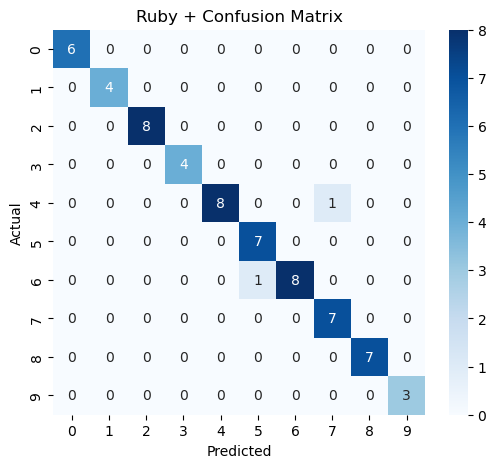

In [25]:
cm = confusion_matrix(labels.numpy(), predicted.numpy())  
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Ruby + Confusion Matrix")
plt.show()


## Save the Model

In [27]:
PATH = "model/Lab6Model.pt"
torch.save(model, PATH)